## Two-layer nn
## f(x) = u^\top tanh(Wx)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.preprocessing import normalize

In [2]:
def cosine_similarity(u ,v):
    return u@v / np.linalg.norm(u) / np.linalg.norm(v)

## Slide 10

In [ ]:
!python gd.py synthetic-cifar-1 fc-tanh-width11-no-bias mse 0.5 5000 --loss_goal 0.00 --eig_freq 100 --save_freq 100 --seed 3 --neigs 10 --eos_log -1 --param_save -1 --grad_step -1 --iterate_freq -1

In [4]:
from archs import load_architecture

In [13]:
dataset = "synthetic-cifar-1" #1000 smaples from cifar10, original feature size, label y=model(x) with some randomly initialized model
model = "fc-tanh-width11-no-bias" #two-layer ff with width=1, see src/archs.py
criterion = "mse"
optimizer = "gd"
lr = "0.5"

In [14]:
dir = f"/mnt/nas/home/chenzhijie/research/edge-of-stability/results/{dataset}/{model}/seed_3/{criterion}/{optimizer}/lr_{lr}/"
eigs = torch.load(dir + "eigs").numpy()

In [15]:
params = []
model = load_architecture(model, dataset)
for i in range(0,3000,300):
    params.append([0,0])
    param_id = 0
    model_path = dir + "model/network_{}.pth".format(i)
    state_dict = torch.load(model_path, map_location=lambda storage, loc: storage)
    model.load_state_dict(state_dict, strict=False)
    for param in model.parameters():
        params[-1][param_id] = param.detach().cpu().numpy().copy()
        param_id += 1

Text(0, 0.5, 'u')

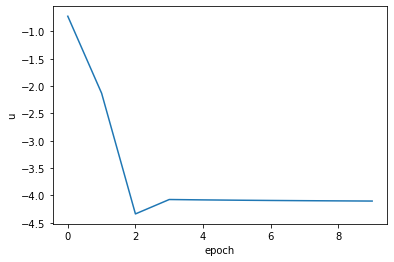

In [16]:
# u (a scalar) vs epoch
u_list = []
for i in range(len(params)):
    u_list.append(params[i][1][0])
plt.plot(u_list)
plt.xlabel("epoch")
plt.ylabel("u")

Text(0, 0.5, 'eigenvalues')

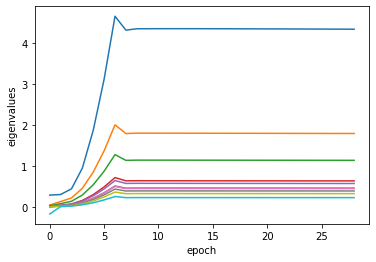

In [17]:
# top eigenvalues
plt.plot(eigs)
plt.xlabel("epoch")
plt.ylabel("eigenvalues")

## Slide 11

In [36]:
dataset_name = "synthetic-cifar-7" #589 samples from cifar10, original image size, output dimension: 7
model = "fc-tanh-width8-no-bias" #two-layer ff with width=50, see src/archs.py
criterion = "mse"
optimizer = "gd"
lr = "2.0"

In [37]:
dir = f"/mnt/nas/home/chenzhijie/research/edge-of-stability/results/{dataset_name}/{model}/seed_3/{criterion}/{optimizer}/lr_{lr}/"
eigs = torch.load(dir + "eigs").numpy()
gn_eigs_w = torch.load(dir + "gauss_newton_eigs_w").numpy()
gn_eigs_u = torch.load(dir + "gauss_newton_eigs_u").numpy()

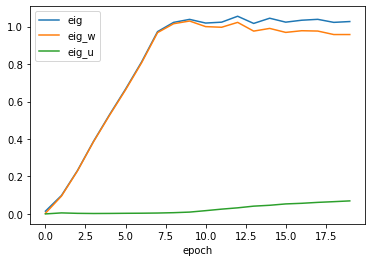

In [38]:
# eigenvalues of hessian, \nabla_w F^\top \nabla_w F, and \nabla_u F^\top \nabla_u F
plt.plot(eigs[:20,0])
plt.plot(gn_eigs_w[:20,0])
plt.plot(gn_eigs_u[:20,0])
plt.xlabel("epoch")
plt.legend(["eig","eig_w","eig_u"])

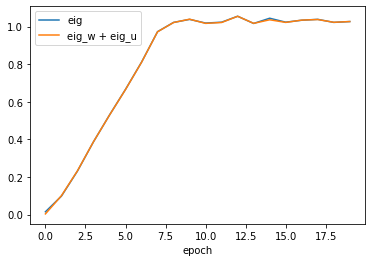

In [48]:
# addition of top eig \nabla_w F^\top \nabla_w F, and top eig of \nabla_u F^\top \nabla_u F
plt.plot(eigs[:20,0])
plt.plot(gn_eigs_w[:20,0] + gn_eigs_u[:20,0])
plt.xlabel("epoch")
plt.legend(["eig","eig_w + eig_u"])

## Slide 13 & 14

In [23]:
dataset_name = "synthetic-reduced-cifar-1" #50 samples from cifar10, feature size:8*8, output dim: 1
model = "fc-tanh-width8-no-bias" #two-layer ff with width=50, see src/archs.py
criterion = "mse"
optimizer = "gd"
lr = "3.0"

In [24]:
dir = f"/mnt/nas/home/chenzhijie/research/edge-of-stability/results/{dataset_name}/{model}/seed_3/{criterion}/{optimizer}/lr_{lr}/"
loss = torch.load(dir + "train_loss").numpy()
eigs = torch.load(dir + "eigs").numpy()
evecs = torch.load(dir + "evecs").numpy()
gradients = torch.load(dir + "grad_vecs").numpy()
hessian_grad_product = torch.load(dir + "hessian_grad_product").numpy()
jacobian = torch.load(dir + "jacobian_100").numpy()
iterates = torch.load(dir +"iterates").numpy()

Text(0, 0.5, 'loss')

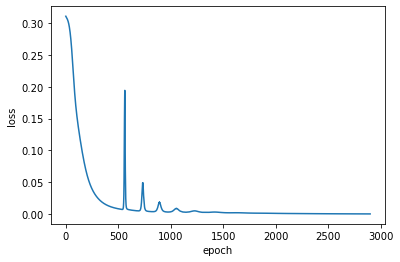

In [34]:
# loss
plt.plot(loss)
plt.xlabel("epoch")
plt.ylabel("loss")

Text(0, 0.5, 'eigs')

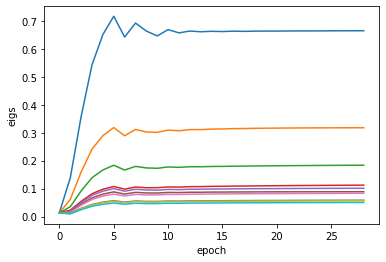

In [35]:
# eigenvalues
plt.plot(eigs)
plt.xlabel("epoch")
plt.ylabel("eigs")

Text(0.5, 1.0, 'Epoch: 2')

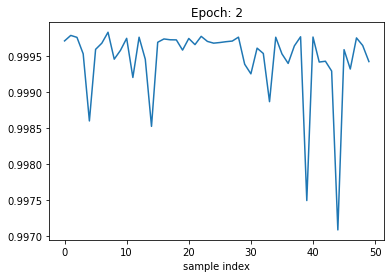

In [27]:
# cosine similarity of successive jacobian vectors
epoch = 2
jac_sim = []
for i in range(jacobian.shape[-1]): #iterate over samples
    jac_sim.append(cosine_similarity(jacobian[epoch,:,i], jacobian[epoch+1,:,i]))
plt.plot(jac_sim)
plt.xlabel("sample index")
plt.title(f"Epoch: {epoch}")

Text(0.5, 0, 'Epoch')

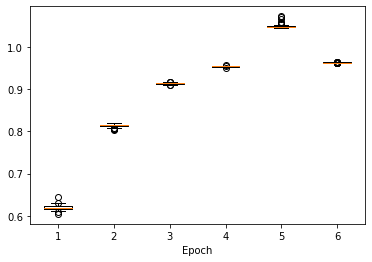

In [29]:
# ratio of successive jacobian norms
jac_sim_epoch = []
for epoch in range(1,7):
    jac_sim = []
    for i in range(jacobian.shape[-1]):
        jac_sim.append(np.linalg.norm(jacobian[epoch,:,i])/np.linalg.norm(jacobian[epoch+1,:,i]))
    jac_sim_epoch.append(jac_sim)
plt.boxplot(jac_sim_epoch)
plt.xlabel("Epoch")

Text(0.5, 0, 'epoch')

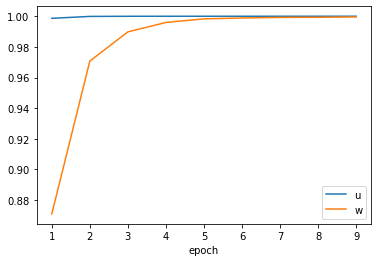

In [28]:
# cosine similarity of successive parameter vectors
u_sim = []
w_sim = []
for epoch in range(1,10):
    u_sim.append(cosine_similarity(iterates[epoch][-50:], iterates[epoch+1][-50:]))
    w_sim.append(cosine_similarity(iterates[epoch][:-50], iterates[epoch+1][:-50]))
plt.plot(np.arange(1,10), u_sim)
plt.plot(np.arange(1,10), w_sim)
plt.legend(["u", "w"])
plt.xlabel("epoch")

Text(0.5, 0, 'epoch')

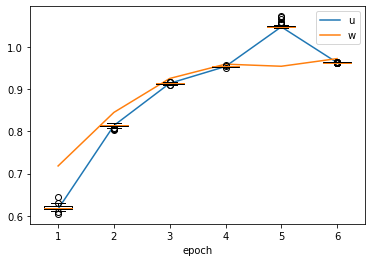

In [30]:
# ratio of successive parameter norms
u_norm_ratio = []
w_norm_ratio = []
for epoch in range(1,7):
    u_norm_ratio.append(np.linalg.norm(iterates[epoch][-50:]) / np.linalg.norm(iterates[epoch+1][-50:]))
    w_norm_ratio.append(np.linalg.norm(iterates[epoch][:-50]) / np.linalg.norm(iterates[epoch+1][:-50]))
plt.plot(np.arange(1,7), u_norm_ratio)
plt.plot(np.arange(1,7), w_norm_ratio)
plt.boxplot(jac_sim_epoch)
plt.legend(["u", "w"])
plt.xlabel("epoch")